In [1]:
from opensoundscape.preprocess.preprocessors import BasePreprocessor, AudioToSpectrogramPreprocessor, CnnPreprocessor
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from opensoundscape.torch.models import cnn
from opensoundscape.torch.architectures import cnn_architectures
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from opensoundscape.annotations import categorical_to_one_hot
import matplotlib.pyplot as plt
from opensoundscape.torch.models.cnn import load_model

### Read the train/validation and test data

In [2]:
train_val_df = pd.read_csv('xeno_canto_train_val.csv')
test_df = pd.read_csv('xeno_canto_test.csv')

In [3]:
train_val_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,0,3.0,44100,White-bellied Tody-Tyrant
1,1,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,3,6.0,44100,White-bellied Tody-Tyrant
2,2,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,6,9.0,44100,White-bellied Tody-Tyrant
3,3,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,9,12.0,44100,White-bellied Tody-Tyrant
4,4,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,12,15.0,44100,White-bellied Tody-Tyrant


In [4]:
test_df.head()

,Unnamed: 0,file,start_time,end_time,SAMPLING RATE,MANUAL ID
0,0,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,0,3.0,44100,White-bellied Tody-Tyrant
1,1,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,3,6.0,44100,White-bellied Tody-Tyrant
2,2,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,6,9.0,44100,White-bellied Tody-Tyrant
3,3,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,9,12.0,44100,White-bellied Tody-Tyrant
4,4,./temp_clips/../XenoCanto_Data/Training_Xeno_C...,12,15.0,44100,White-bellied Tody-Tyrant


### Check counts of the different classes in both the dataframes

In [5]:
train_val_df['MANUAL ID'].value_counts()

White-throated Toucan        3776
Red-eyed Vireo               1886
Eastern Kingbird             1403
White-bellied Tody-Tyrant    1018
None                          951
Ihering's Antwren             295
Great-billed Hermit           237
Chivi Vireo                   234
Philadelphia Vireo             60
Scissor-tailed Flycatcher      58
Black-and-white Warbler        50
Creamy-bellied Thrush          50
Wood Thrush                    41
Yellow-throated Toucan         28
Noronha Vireo                  26
Brown Bullfinch                26
Yellow-bellied Flycatcher      19
Bamboo Antshrike               19
Long-billed Hermit             17
Water Rail                     15
Philippine Woodpecker          12
Brown Violetear                11
Yellow-green Vireo             11
Striated Antbird               11
Blue-backed Manakin            11
Channel-billed Toucan           9
White-throated Spadebill        8
Brown-headed Cowbird            8
Mountain Scops-Owl              6
White-browed T

In [6]:
test_df['MANUAL ID'].value_counts()

White-throated Toucan        107
Ihering's Antwren            102
Red-eyed Vireo                98
Brassy-breasted Tanager       91
Eastern Kingbird              85
White-bellied Tody-Tyrant     83
None                          66
Charming Hummingbird          26
Bluish-slate Antshrike        25
Chivi Vireo                    4
Name: MANUAL ID, dtype: int64

### Changing species' names to a simpler version for convenience

In [7]:
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Toucan'), 'MANUAL ID'] = 'Toucan'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Flycatcher'), 'MANUAL ID'] = 'Flycatcher'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Thrush'), 'MANUAL ID'] = 'Thrush'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Vireo'), 'MANUAL ID'] = 'Vireo'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antwren'), 'MANUAL ID'] = 'Antwren'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tanager'), 'MANUAL ID'] = 'Tanager'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Kingbird'), 'MANUAL ID'] = 'Kingbird'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Tody-Tyrant'), 'MANUAL ID'] = 'Tody-Tyrant'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Hummingbird'), 'MANUAL ID'] = 'Hummingbird'
train_val_df.loc[train_val_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = test_df.loc[test_df['MANUAL ID'].str.contains('Antshrike'), 'MANUAL ID'] = 'Antshrike'

### Remove rows from dataframes which are not the species of our interest

In [8]:
classes = ['Antwren', 'Antshrike', 'Toucan', 'Vireo', 'Kingbird', 'Tody-Tyrant', 'None']
for i, row in train_val_df.iterrows():
    if(row['MANUAL ID'] not in classes):
        train_val_df.drop(i, inplace=True)
for i, row in test_df.iterrows():
    if(row['MANUAL ID'] not in classes):
        test_df.drop(i, inplace=True)
print('Classwise Counts for train/val data:')
print(train_val_df['MANUAL ID'].value_counts())
print('\nClasswise  Counts for test data:')
print(test_df['MANUAL ID'].value_counts())

Classwise Counts for train/val data:
Toucan         3813
Vireo          2217
Kingbird       1403
Tody-Tyrant    1018
None            951
Antwren         295
Antshrike        19
Name: MANUAL ID, dtype: int64

Classwise  Counts for test data:
Toucan         107
Antwren        102
Vireo          102
Kingbird        85
Tody-Tyrant     83
None            66
Antshrike       25
Name: MANUAL ID, dtype: int64


### Convert the train/val and test data to one-hot representations of the classes

In [9]:
# Train/val
one_hot_labels, train_classes = categorical_to_one_hot(train_val_df[['MANUAL ID']].values)
train_val_df = pd.DataFrame(index=train_val_df['file'],data=one_hot_labels,columns=train_classes)

# Test
one_hot_labels, test_classes = categorical_to_one_hot(test_df[['MANUAL ID']].values)
test_df = pd.DataFrame(index=test_df['file'],data=one_hot_labels,columns=test_classes)

### Split the trainining/validation dataframe into training and validation sets

In [10]:
train_df, valid_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [11]:
print("Number of training examples : ", train_df.shape[0])
print("Number of validation examples : ", valid_df.shape[0])
print("Number of test examples : ", test_df.shape[0])

Number of training examples :  7772
Number of validation examples :  1944
Number of test examples :  570


### Prepare the training and validation set for the CNN model

In [12]:
train_dataset = CnnPreprocessor(df=train_df)
train_dataset.augmentation_on()
train_dataset.actions.load_audio.set(sample_rate=44100)
valid_dataset = CnnPreprocessor(df=valid_df)
valid_dataset.augmentation_on()
valid_dataset.actions.load_audio.set(sample_rate=44100)

### Create the Resnet-18 Multiclass model and train it

In [13]:
model = cnn.Resnet18Multiclass(train_classes)

created PytorchModel model object with 7 classes


In [14]:
model.sampler = 'imbalanced'
model.train(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    save_path='./multilabel_train_seven_classes_xeno_canto/',
    epochs=10,
    batch_size=32,
    save_interval=100,
    num_workers=2
)

Epoch: 0 [batch 0/243 (0.00%)] 
	Jacc: 0.140 Hamm: 0.844 DistLoss: 31.112
Epoch: 0 [batch 10/243 (4.12%)] 
	Jacc: 0.000 Hamm: 0.143 DistLoss: 24.087
Epoch: 0 [batch 20/243 (8.23%)] 
	Jacc: 0.276 Hamm: 0.112 DistLoss: 21.332
Epoch: 0 [batch 30/243 (12.35%)] 
	Jacc: 0.342 Hamm: 0.098 DistLoss: 18.732
Epoch: 0 [batch 40/243 (16.46%)] 
	Jacc: 0.440 Hamm: 0.094 DistLoss: 16.262
Epoch: 0 [batch 50/243 (20.58%)] 
	Jacc: 0.631 Hamm: 0.054 DistLoss: 14.433
Epoch: 0 [batch 60/243 (24.69%)] 
	Jacc: 0.780 Hamm: 0.031 DistLoss: 12.860
Epoch: 0 [batch 70/243 (28.81%)] 
	Jacc: 0.849 Hamm: 0.031 DistLoss: 11.730
Epoch: 0 [batch 80/243 (32.92%)] 
	Jacc: 0.821 Hamm: 0.031 DistLoss: 10.851
Epoch: 0 [batch 90/243 (37.04%)] 
	Jacc: 0.748 Hamm: 0.040 DistLoss: 10.211
Epoch: 0 [batch 100/243 (41.15%)] 
	Jacc: 0.800 Hamm: 0.031 DistLoss: 9.672
Epoch: 0 [batch 110/243 (45.27%)] 
	Jacc: 0.693 Hamm: 0.036 DistLoss: 9.201
Epoch: 0 [batch 120/243 (49.38%)] 
	Jacc: 0.888 Hamm: 0.018 DistLoss: 8.752
Epoch: 0 [batch 

Epoch: 4 [batch 30/243 (12.35%)] 
	Jacc: 0.876 Hamm: 0.022 DistLoss: 1.396
Epoch: 4 [batch 40/243 (16.46%)] 
	Jacc: 0.929 Hamm: 0.009 DistLoss: 1.371
Epoch: 4 [batch 50/243 (20.58%)] 
	Jacc: 0.811 Hamm: 0.027 DistLoss: 1.380
Epoch: 4 [batch 60/243 (24.69%)] 
	Jacc: 0.908 Hamm: 0.013 DistLoss: 1.390
Epoch: 4 [batch 70/243 (28.81%)] 
	Jacc: 0.951 Hamm: 0.009 DistLoss: 1.379
Epoch: 4 [batch 80/243 (32.92%)] 
	Jacc: 0.917 Hamm: 0.013 DistLoss: 1.354
Epoch: 4 [batch 90/243 (37.04%)] 
	Jacc: 0.927 Hamm: 0.013 DistLoss: 1.371
Epoch: 4 [batch 100/243 (41.15%)] 
	Jacc: 0.868 Hamm: 0.027 DistLoss: 1.370
Epoch: 4 [batch 110/243 (45.27%)] 
	Jacc: 0.805 Hamm: 0.027 DistLoss: 1.376
Epoch: 4 [batch 120/243 (49.38%)] 
	Jacc: 0.753 Hamm: 0.018 DistLoss: 1.370


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4 [batch 130/243 (53.50%)] 
	Jacc: 0.912 Hamm: 0.018 DistLoss: 1.391
Epoch: 4 [batch 140/243 (57.61%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 1.391
Epoch: 4 [batch 150/243 (61.73%)] 
	Jacc: 0.976 Hamm: 0.004 DistLoss: 1.386
Epoch: 4 [batch 160/243 (65.84%)] 
	Jacc: 0.936 Hamm: 0.009 DistLoss: 1.361
Epoch: 4 [batch 170/243 (69.96%)] 
	Jacc: 0.815 Hamm: 0.031 DistLoss: 1.356
Epoch: 4 [batch 180/243 (74.07%)] 
	Jacc: 0.896 Hamm: 0.013 DistLoss: 1.375
Epoch: 4 [batch 190/243 (78.19%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 1.393
Epoch: 4 [batch 200/243 (82.30%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 1.406
Epoch: 4 [batch 210/243 (86.42%)] 
	Jacc: 0.893 Hamm: 0.013 DistLoss: 1.408
Epoch: 4 [batch 220/243 (90.53%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 1.412
Epoch: 4 [batch 230/243 (94.65%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 1.399
Epoch: 4 [batch 240/243 (98.77%)] 
	Jacc: 0.871 Hamm: 0.013 DistLoss: 1.400

Validation.
(1944, 7)
	 Precision: 0.8617645988314907
	 Recall: 0.9508381446354159
	 F1

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5 [batch 240/243 (98.77%)] 
	Jacc: 0.906 Hamm: 0.013 DistLoss: 1.125

Validation.
(1944, 7)
	 Precision: 0.9742095179959922
	 Recall: 0.8868915467774171
	 F1: 0.9181684621030705
Epoch: 6 [batch 0/243 (0.00%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 0.472
Epoch: 6 [batch 10/243 (4.12%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.551
Epoch: 6 [batch 20/243 (8.23%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.705
Epoch: 6 [batch 30/243 (12.35%)] 
	Jacc: 0.982 Hamm: 0.004 DistLoss: 0.769
Epoch: 6 [batch 40/243 (16.46%)] 
	Jacc: 0.929 Hamm: 0.009 DistLoss: 0.838
Epoch: 6 [batch 50/243 (20.58%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.838
Epoch: 6 [batch 60/243 (24.69%)] 
	Jacc: 0.980 Hamm: 0.004 DistLoss: 0.784
Epoch: 6 [batch 70/243 (28.81%)] 
	Jacc: 0.971 Hamm: 0.004 DistLoss: 0.838
Epoch: 6 [batch 80/243 (32.92%)] 
	Jacc: 0.929 Hamm: 0.009 DistLoss: 0.825
Epoch: 6 [batch 90/243 (37.04%)] 
	Jacc: 0.948 Hamm: 0.009 DistLoss: 0.866
Epoch: 6 [batch 100/243 (41.15%)] 
	Jacc: 0.956 Hamm: 0.009 DistLoss:

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8 [batch 160/243 (65.84%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 0.790
Epoch: 8 [batch 170/243 (69.96%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.796
Epoch: 8 [batch 180/243 (74.07%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.809
Epoch: 8 [batch 190/243 (78.19%)] 
	Jacc: 0.952 Hamm: 0.009 DistLoss: 0.812
Epoch: 8 [batch 200/243 (82.30%)] 
	Jacc: 0.908 Hamm: 0.013 DistLoss: 0.810
Epoch: 8 [batch 210/243 (86.42%)] 
	Jacc: 0.869 Hamm: 0.013 DistLoss: 0.807
Epoch: 8 [batch 220/243 (90.53%)] 
	Jacc: 0.816 Hamm: 0.027 DistLoss: 0.806
Epoch: 8 [batch 230/243 (94.65%)] 
	Jacc: 0.964 Hamm: 0.004 DistLoss: 0.785
Epoch: 8 [batch 240/243 (98.77%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.786

Validation.
(1944, 7)
	 Precision: 0.9605061601273517
	 Recall: 0.9695540445064024
	 F1: 0.9643638485911177
Updating best model
Epoch: 9 [batch 0/243 (0.00%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.134
Epoch: 9 [batch 10/243 (4.12%)] 
	Jacc: 0.881 Hamm: 0.009 DistLoss: 1.009
Epoch: 9 [batch 20/243 (8.23%)] 
	Jacc: 

/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 512 is greater than input length  = 468, using nperseg = 468
  .format(nperseg, input_length))


Epoch: 9 [batch 160/243 (65.84%)] 
	Jacc: 0.929 Hamm: 0.009 DistLoss: 0.767
Epoch: 9 [batch 170/243 (69.96%)] 
	Jacc: 0.778 Hamm: 0.013 DistLoss: 0.762


/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9 [batch 180/243 (74.07%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.741
Epoch: 9 [batch 190/243 (78.19%)] 
	Jacc: 0.962 Hamm: 0.009 DistLoss: 0.741
Epoch: 9 [batch 200/243 (82.30%)] 
	Jacc: 0.944 Hamm: 0.009 DistLoss: 0.742
Epoch: 9 [batch 210/243 (86.42%)] 
	Jacc: 0.952 Hamm: 0.004 DistLoss: 0.744
Epoch: 9 [batch 220/243 (90.53%)] 
	Jacc: 0.936 Hamm: 0.009 DistLoss: 0.749
Epoch: 9 [batch 230/243 (94.65%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.758
Epoch: 9 [batch 240/243 (98.77%)] 
	Jacc: 1.000 Hamm: 0.000 DistLoss: 0.752

Validation.
(1944, 7)
	 Precision: 0.9653980060213484
	 Recall: 0.9648395684875034
	 F1: 0.9647742532188641
Saving weights, metrics, and train/valid scores.
Updating best model

Best Model Appears at Epoch 9 with F1 0.965.


### Plot the loss

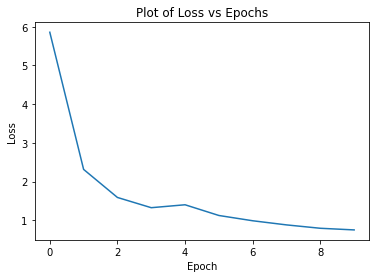

In [15]:
plt.plot(model.loss_hist.keys(),model.loss_hist.values())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Plot of Loss vs Epochs')
plt.show()

### Load the best model (based on validation set) and evaluate on test set

In [16]:
model = load_model('./multilabel_train_seven_classes_xeno_canto/best.model')
prediction_dataset = model.train_dataset.sample(n=0)
prediction_dataset.augmentation_off()
prediction_dataset.df = test_df

In [17]:
prediction_dataset.df

,Kingbird,None,Vireo,Antshrike,Tody-Tyrant,Antwren,Toucan
file,,,,,,,
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_0.0s_3.0s.wav,0,0,0,0,1,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_3.0s_6.0s.wav,0,0,0,0,1,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_6.0s_9.0s.wav,0,0,0,0,1,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_9.0s_12.0s.wav,0,0,0,0,1,0,0
./temp_clips/../XenoCanto_Data/Training_Xeno_Canto_2022/Hemitriccus-griseipectus-11801_12.0s_15.0s.wav,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
./temp_clips/../Absent/20190705_171000_15.WAV,0,1,0,0,0,0,0
./temp_clips/../Absent/20190705_171000_16.WAV,0,1,0,0,0,0,0
./temp_clips/../Absent/20190705_171000_17.WAV,0,1,0,0,0,0,0


In [18]:
valid_scores_df, valid_preds_df, valid_labels_df = model.predict(prediction_dataset,
                                                                 binary_preds='single_target',
                                                                 batch_size=16,
                                                                 num_workers=2,
                                                                 activation_layer='softmax')

(570, 7)


#### Print various metrics for the test set predictions

In [19]:
print(classification_report(valid_labels_df, valid_preds_df))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        85
           1       1.00      1.00      1.00        66
           2       0.99      0.97      0.98       102
           3       0.00      0.00      0.00        25
           4       1.00      0.98      0.99        83
           5       0.81      0.75      0.78       102
           6       0.82      0.98      0.89       107

   micro avg       0.89      0.89      0.89       570
   macro avg       0.78      0.81      0.79       570
weighted avg       0.86      0.89      0.87       570
 samples avg       0.89      0.89      0.89       570



/home/shreyas/miniconda3/envs/opensoundscape/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Plot the RIC curve and report AOC

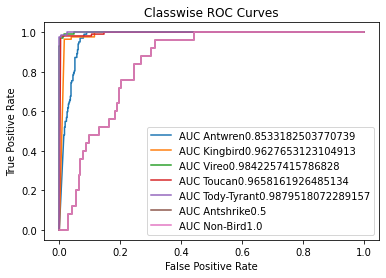

In [20]:
fpr, tpr, thresh = roc_curve(valid_labels_df['Antwren'],  valid_scores_df['Antwren'])
auc = roc_auc_score(valid_labels_df['Antwren'],  valid_preds_df['Antwren'])

fpr2, tpr2, thresh2 = roc_curve(valid_labels_df['Kingbird'],  valid_scores_df['Kingbird'])
auc2 = roc_auc_score(valid_labels_df['Kingbird'],  valid_preds_df['Kingbird'])

fpr3, tpr3, thresh3 = roc_curve(valid_labels_df['Vireo'],  valid_scores_df['Vireo'])
auc3 = roc_auc_score(valid_labels_df['Vireo'],  valid_preds_df['Vireo'])

fpr4, tpr4, thresh4 = roc_curve(valid_labels_df['Toucan'],  valid_scores_df['Toucan'])
auc4 = roc_auc_score(valid_labels_df['Toucan'],  valid_preds_df['Toucan'])

fpr5, tpr5, thresh5 = roc_curve(valid_labels_df['Tody-Tyrant'],  valid_scores_df['Tody-Tyrant'])
auc5 = roc_auc_score(valid_labels_df['Tody-Tyrant'],  valid_preds_df['Tody-Tyrant'])

fpr6, tpr6, thresh6 = roc_curve(valid_labels_df['Antshrike'],  valid_scores_df['Antshrike'])
auc6 = roc_auc_score(valid_labels_df['Antshrike'],  valid_preds_df['Antshrike'])

fpr7, tpr7, thresh7 = roc_curve(valid_labels_df['None'],  valid_scores_df['None'])
auc7 = roc_auc_score(valid_labels_df['None'],  valid_preds_df['None'])

plt.plot(fpr,tpr,label="AUC Antwren"+str(auc))
plt.plot(fpr2,tpr2,label="AUC Kingbird"+str(auc2))
plt.plot(fpr3,tpr3,label="AUC Vireo"+str(auc3))
plt.plot(fpr4,tpr4,label="AUC Toucan"+str(auc4))
plt.plot(fpr5,tpr5,label="AUC Tody-Tyrant"+str(auc5))
plt.plot(fpr6,tpr6,label="AUC Antshrike"+str(auc6))
plt.plot(fpr6,tpr6,label="AUC Non-Bird"+str(auc7))
plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()